<a href="https://colab.research.google.com/github/RIO-bn/data-analaytics-projects/blob/main/Data_analytics_fitur_classification_furniture_revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DatasetClean.csv to DatasetClean (1).csv


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier  # ✅ Import model CatBoost

import warnings
warnings.filterwarnings("ignore")

# Load data


df = pd.read_csv("DatasetClean.csv")
#notes jika 0 itu rugi dan 1 itu untuk untung
df['target'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)
X_all = df.drop(columns=['revenue', 'target'])
y = df['target']

# ✅ Split dataset menjadi train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ukuran Training Set: {len(X_train)}")
print(f"Ukuran Validasi Set: {len(X_val)}")
print(f"Ukuran Test Set: {len(X_test)}")
cat_features = X_train.select_dtypes(include='object').columns.tolist()


Ukuran Training Set: 1750
Ukuran Validasi Set: 375
Ukuran Test Set: 375



=== Evaluation on Validation Set ===
              precision    recall  f1-score   support

           0       0.29      0.06      0.09        72
           1       0.81      0.97      0.88       303

    accuracy                           0.79       375
   macro avg       0.55      0.51      0.49       375
weighted avg       0.71      0.79      0.73       375

ROC AUC (Validation): 0.7660


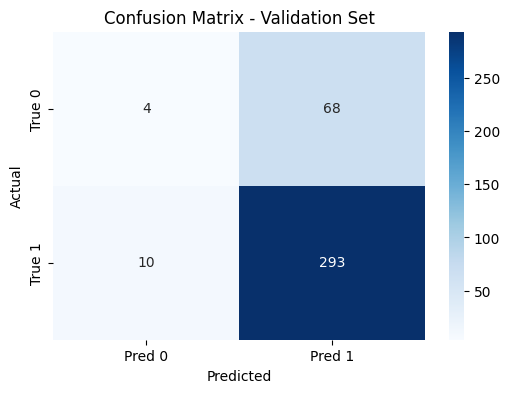


=== Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.42      0.06      0.10        85
           1       0.78      0.98      0.87       290

    accuracy                           0.77       375
   macro avg       0.60      0.52      0.48       375
weighted avg       0.70      0.77      0.69       375

ROC AUC (Test): 0.7804


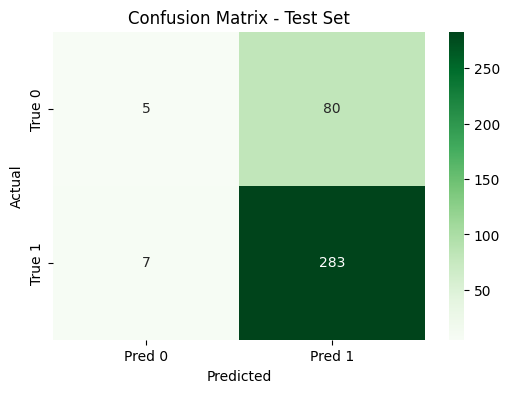

In [ ]:
# Parameter terbaik CatBoost yang kami dpaatkan di ipynb sebelumnya melalui gridsearch

cat_params = {
    'depth': 5,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'random_seed': 42,
    'verbose': 0
}

# ✅ Train model dengan seluruh fitur
model1 = CatBoostClassifier(**cat_params)
model1.fit(X_train, y_train, cat_features=cat_features)

# ✅ Validasi di validation set
y_val_pred = model1.predict(X_val)
y_val_proba = model1.predict_proba(X_val)[:, 1]

print("\n=== Evaluation on Validation Set ===")
val_report = classification_report(y_val, y_val_pred)
print(val_report)
val_auc = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC (Validation): {val_auc:.4f}")

# Confusion Matrix Validation
val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Final test set evaluation
y_test_pred = model1.predict(X_test)
y_test_proba = model1.predict_proba(X_test)[:, 1]

print("\n=== Evaluation on Test Set ===")
test_report = classification_report(y_test, y_test_pred)
print(test_report)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC (Test): {test_auc:.4f}")

# Confusion Matrix Test
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



=== Evaluation on Validation Set ===
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        72
           1       0.82      0.98      0.89       303

    accuracy                           0.81       375
   macro avg       0.66      0.53      0.52       375
weighted avg       0.76      0.81      0.75       375

ROC AUC (Validation): 0.7628


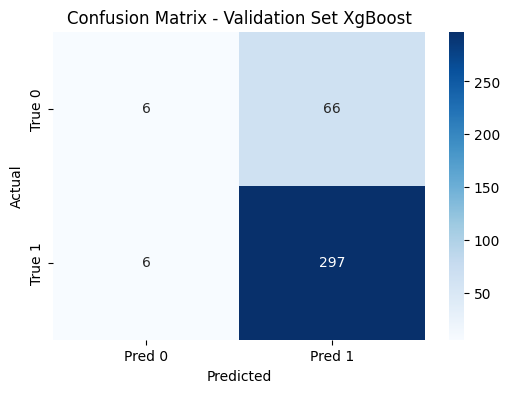


=== Evaluation on Test Set === XGBoost
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        85
           1       0.78      0.99      0.87       290

    accuracy                           0.77       375
   macro avg       0.64      0.51      0.47       375
weighted avg       0.71      0.77      0.69       375

ROC AUC (Test): 0.7823


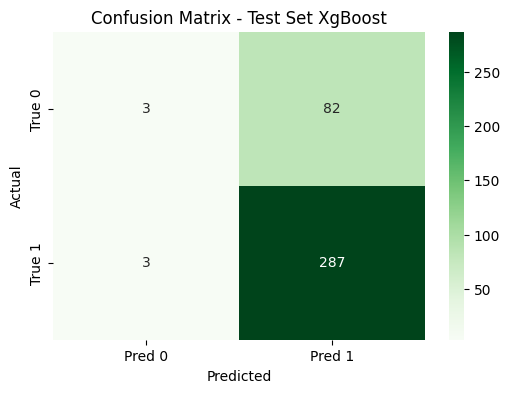

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Pisahkan fitur numerik dan kategorikal
categorical_cols = X_all.select_dtypes(include='object').columns.tolist()
numerical_cols = X_all.select_dtypes(exclude='object').columns.tolist()

# Buat ColumnTransformer untuk OneHotEncoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # biarkan fitur numerik tetap
)

# Transform dataset
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)
xgb_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'random_state': 42,
    'subsample': 0.7,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

model2 = XGBClassifier(**xgb_params)
model2.fit(X_train_encoded, y_train)

# ✅ Validasi di validation set
y_val_pred = model2.predict(X_val_encoded)
y_val_proba = model2.predict_proba(X_val_encoded)[:, 1]

print("\n=== Evaluation on Validation Set ===")
val_report = classification_report(y_val, y_val_pred)
print(val_report)
val_auc = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC (Validation): {val_auc:.4f}")

# Confusion Matrix Validation
val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Validation Set XgBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Final test set evaluation
y_test_pred = model2.predict(X_test_encoded)
y_test_proba = model2.predict_proba(X_test_encoded)[:, 1]

print("\n=== Evaluation on Test Set === XGBoost")
test_report = classification_report(y_test, y_test_pred)
print(test_report)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC (Test): {test_auc:.4f}")

# Confusion Matrix Test
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Test Set XgBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




=== Evaluation on Validation Set (Random Forest) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.81      1.00      0.89       303

    accuracy                           0.81       375
   macro avg       0.40      0.50      0.45       375
weighted avg       0.65      0.81      0.72       375

ROC AUC (Validation - RF): 0.7682


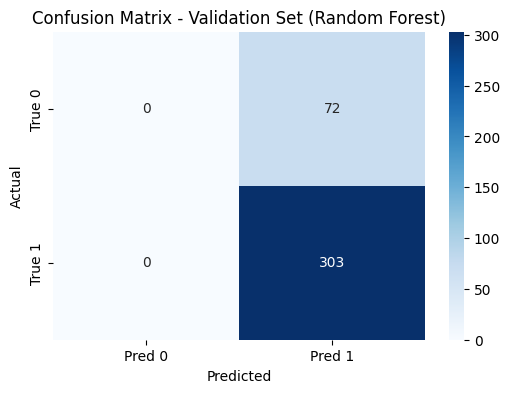


=== Evaluation on Test Set (Random Forest) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.77      1.00      0.87       290

    accuracy                           0.77       375
   macro avg       0.39      0.50      0.44       375
weighted avg       0.60      0.77      0.67       375

ROC AUC (Test - RF): 0.7701


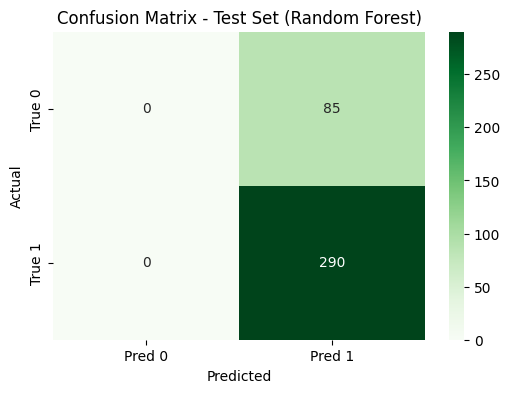

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pisahkan fitur kategorikal dan numerik
categorical_cols = X_all.select_dtypes(include='object').columns.tolist()
numerical_cols = X_all.select_dtypes(exclude='object').columns.tolist()

# Preprocessing: OneHotEncoding untuk kategori
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # biarkan fitur numerik tetap
)

# Transform data
X_train_rf = preprocessor_rf.fit_transform(X_train)
X_val_rf = preprocessor_rf.transform(X_val)
X_test_rf = preprocessor_rf.transform(X_test)

# Parameter terbaik untuk Random Forest
rf_params = {
    'max_depth': 5,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 500,
    'random_state': 42
}

# Inisialisasi & latih model
model3 = RandomForestClassifier(**rf_params)
model3.fit(X_train_rf, y_train)

# ✅ Evaluasi di validation set
y_val_pred_rf = model3.predict(X_val_rf)
y_val_proba_rf = model3.predict_proba(X_val_rf)[:, 1]

print("\n=== Evaluation on Validation Set (Random Forest) ===")
val_report_rf = classification_report(y_val, y_val_pred_rf)
print(val_report_rf)
val_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
print(f"ROC AUC (Validation - RF): {val_auc_rf:.4f}")

# Confusion Matrix Validation
val_cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Validation Set (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Evaluasi di test set
y_test_pred_rf = model3.predict(X_test_rf)
y_test_proba_rf = model3.predict_proba(X_test_rf)[:, 1]

print("\n=== Evaluation on Test Set (Random Forest) ===")
test_report_rf = classification_report(y_test, y_test_pred_rf)
print(test_report_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)
print(f"ROC AUC (Test - RF): {test_auc_rf:.4f}")

# Confusion Matrix Test
test_cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Test Set (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()